### Runs our trained U-Net based model on test dataset and save results


Runing on: cpu
Train images: 96 (augmentation: True)
Test images: 24 (augmentation: False)
Model loaded on: cpu

7-original_hsv 2020-06-21 20:59:26.627475
	Batch 1: 1/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:26.769205
	Batch 2: 2/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:29.515224
	Batch 3: 3/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:31.653496
	Batch 4: 4/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:33.593115
	Batch 5: 5/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:35.383227
	Batch 6: 6/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:37.212257
	Batch 7: 7/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 20:59:39.048687
	Batch 8: 8/24 images: torch.Size([1, 3, 256, 448]) masks: t

/home/dalifreire/miniconda3/envs/human_oral_tissues_segmentation/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


	Batch 22: 22/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:18.107730
	Batch 23: 23/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:20.279874
	Batch 24: 24/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:22.738988
Train images: 96 (augmentation: True)
Test images: 24 (augmentation: False)
Model loaded on: cpu

8-original_lab 2020-06-21 21:00:26.681389
	Batch 1: 1/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:26.880099
	Batch 2: 2/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:29.733669
	Batch 3: 3/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:32.308770
	Batch 4: 4/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size([1, 256, 448]) 2020-06-21 21:00:34.745494
	Batch 5: 5/24 images: torch.Size([1, 3, 256, 448]) masks: torch.Size(

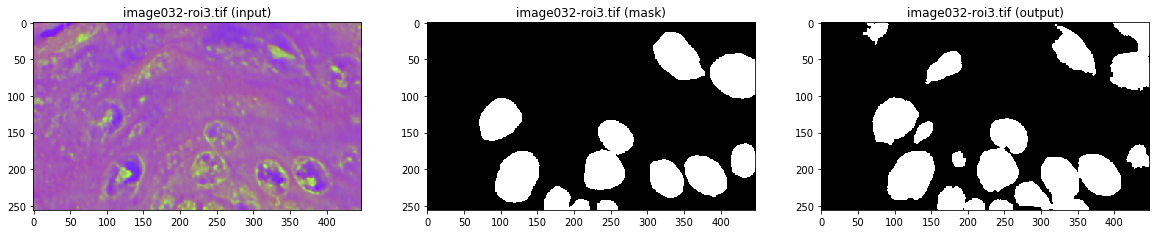

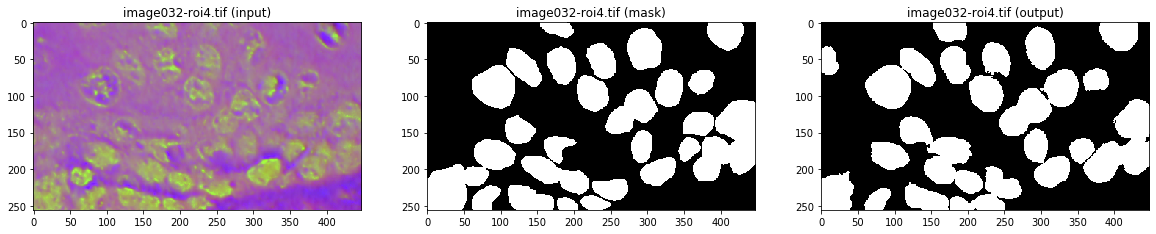

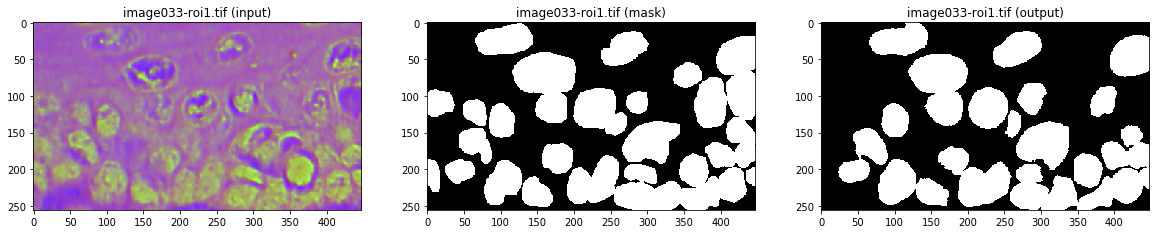

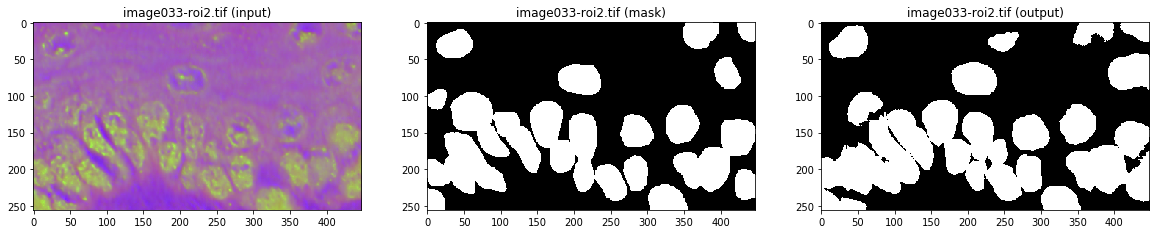

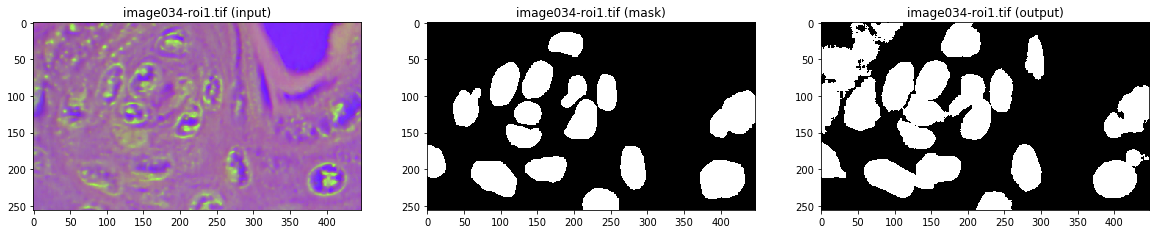

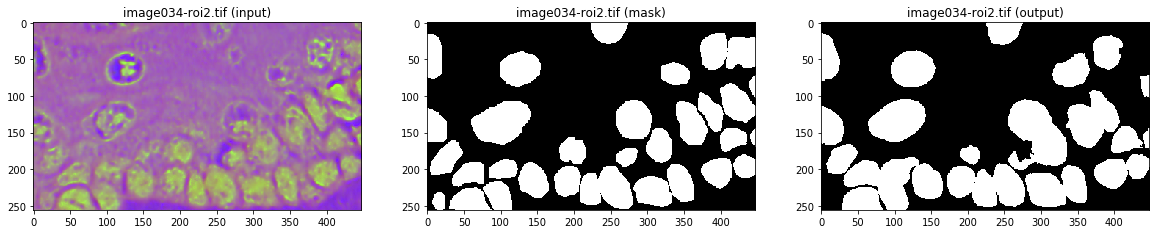

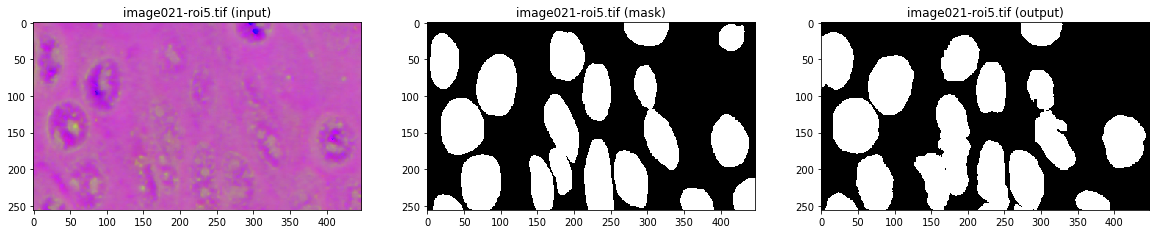

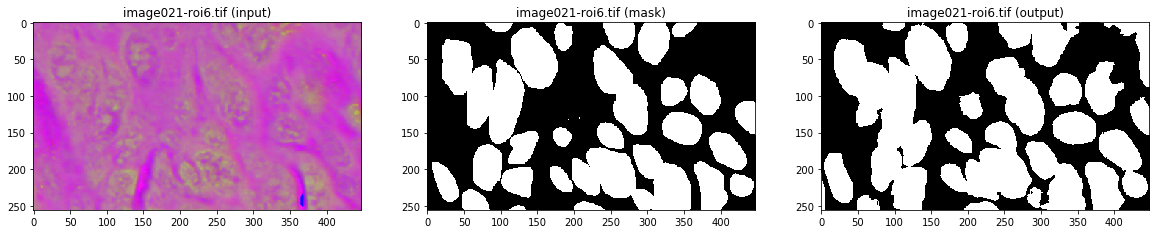

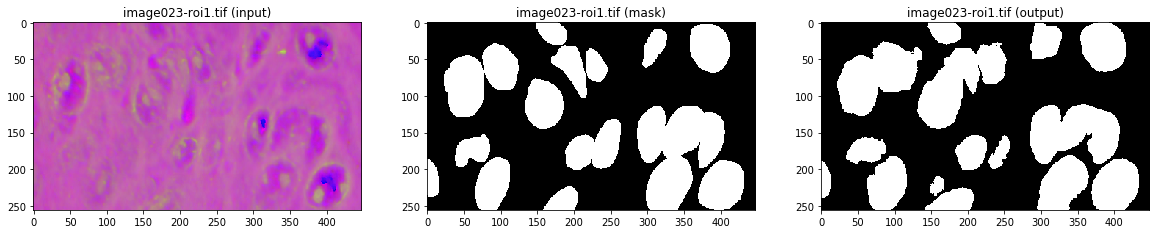

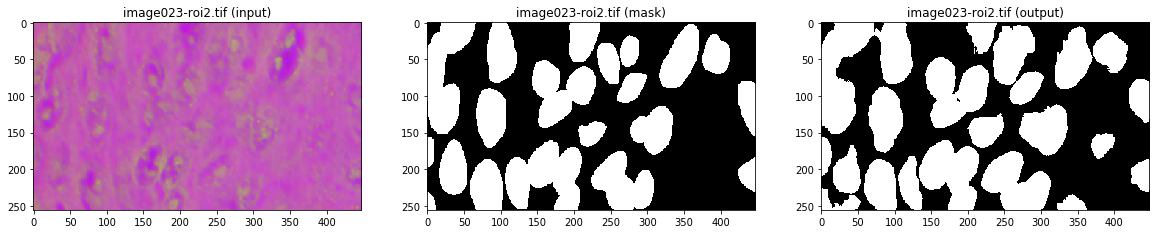

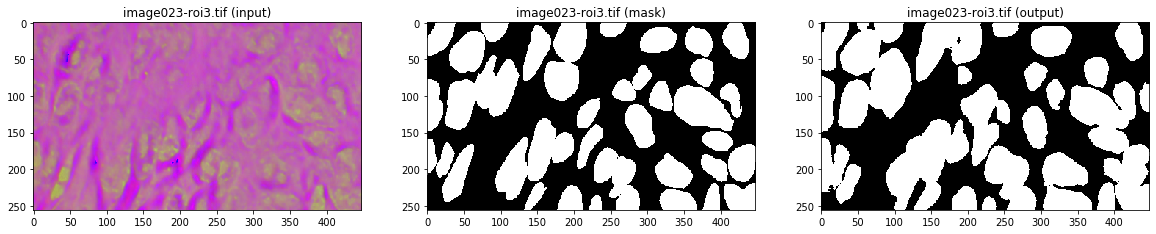

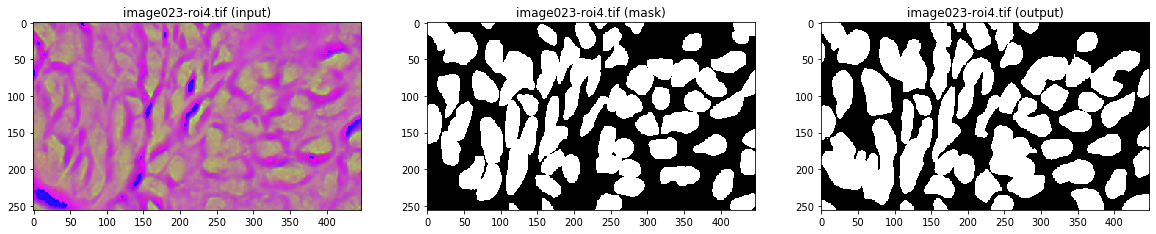

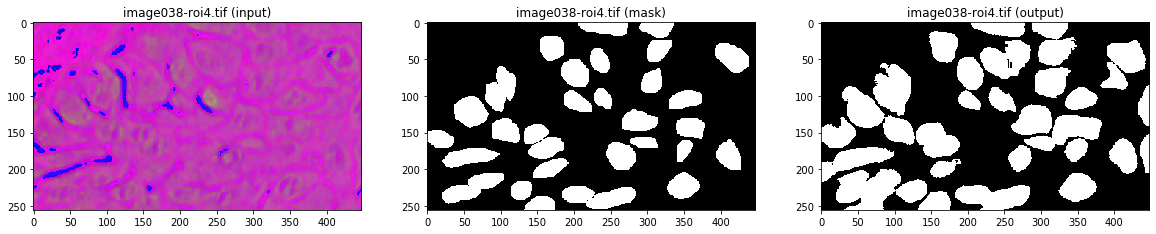

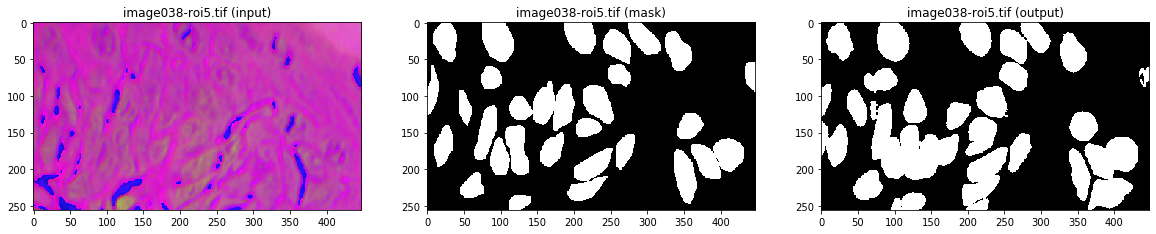

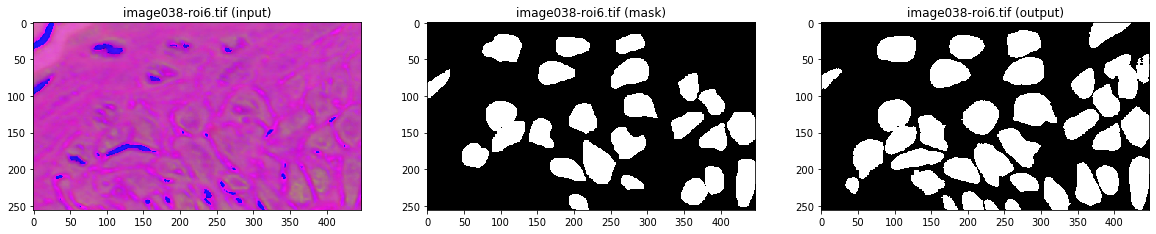

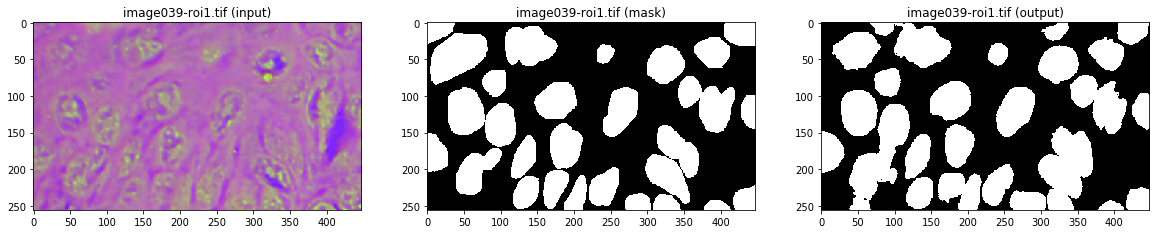

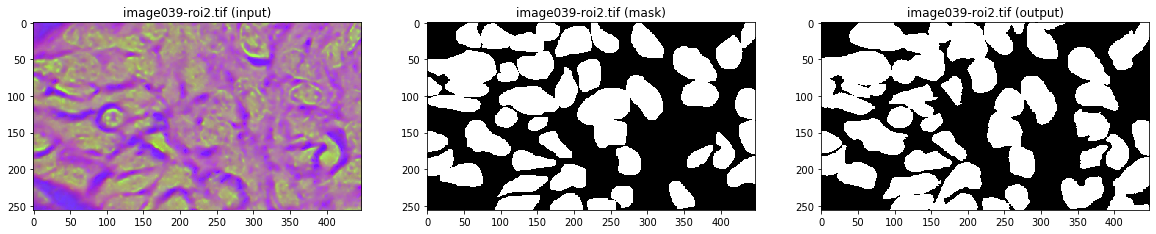

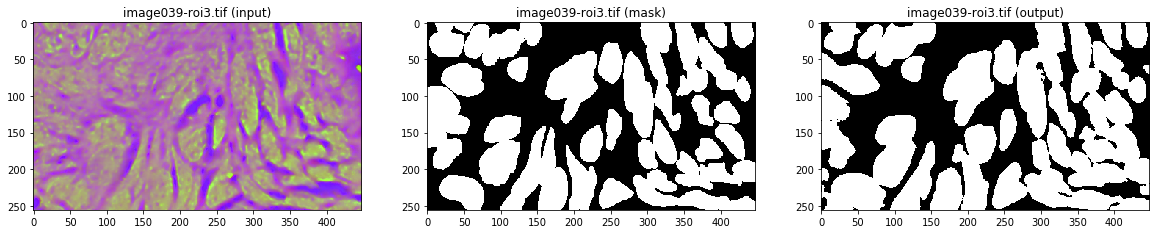

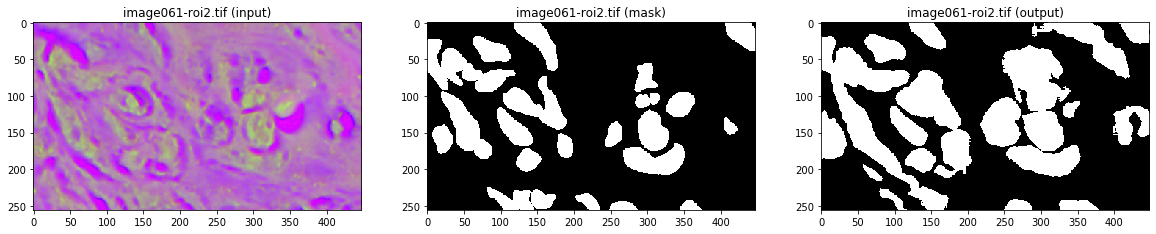

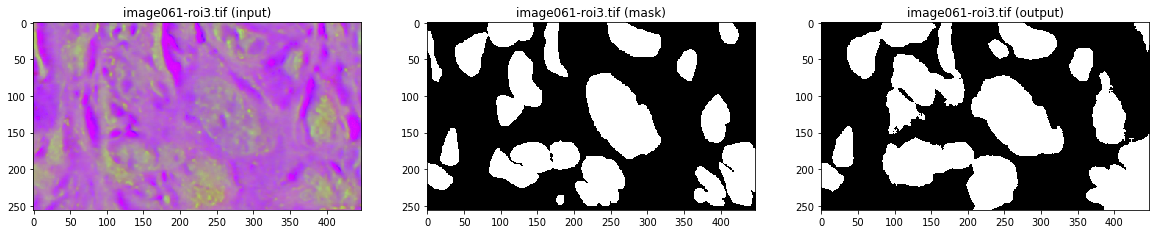

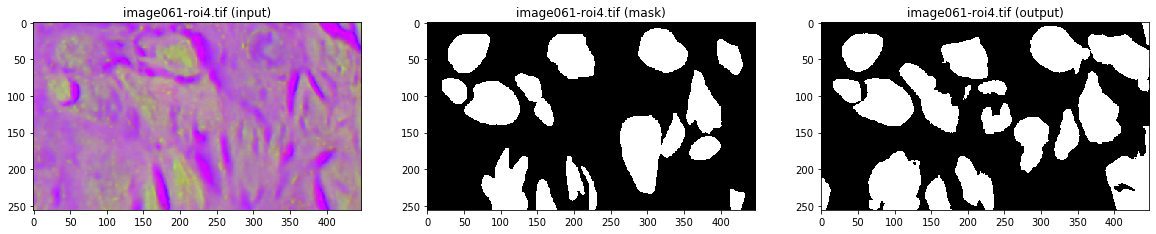

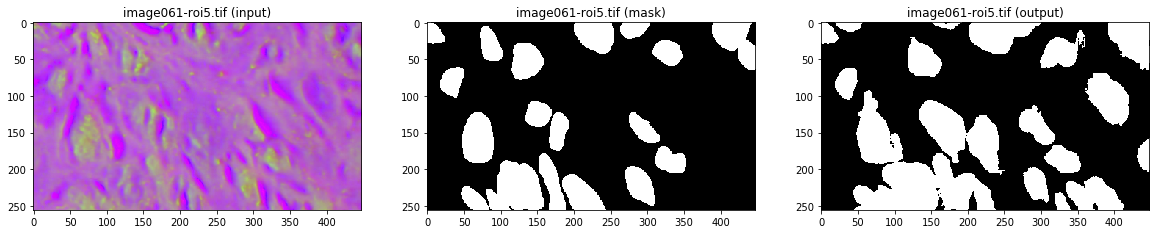

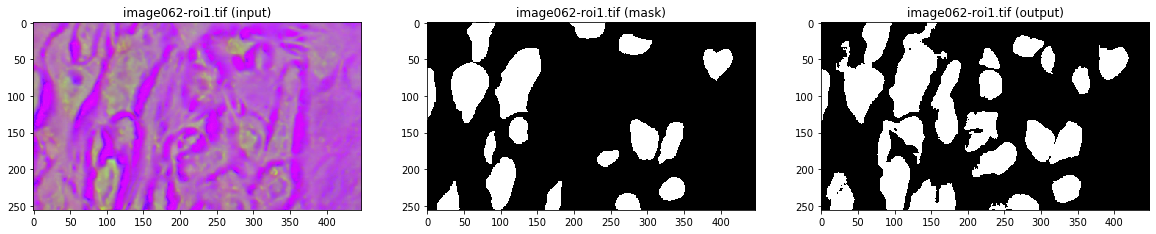

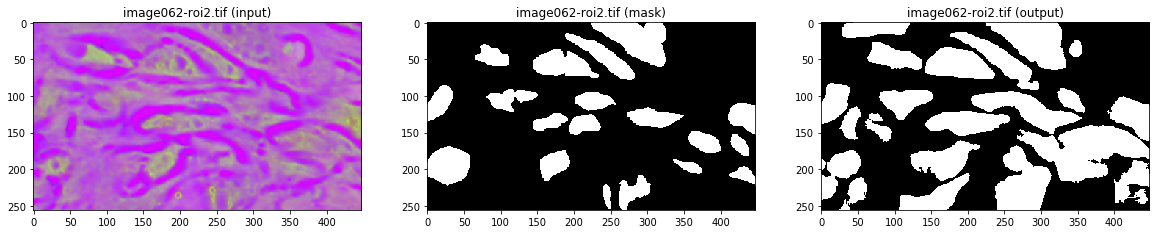

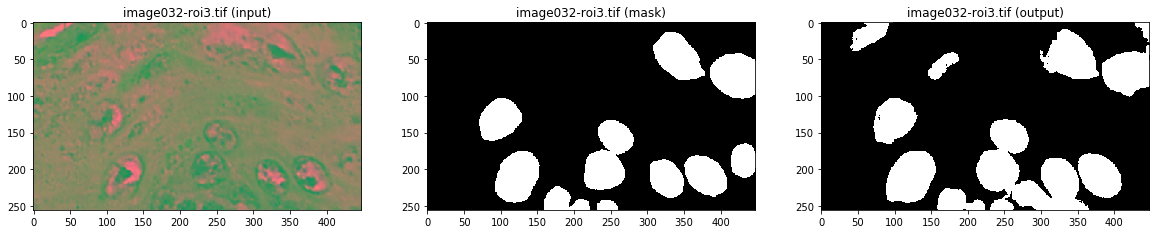

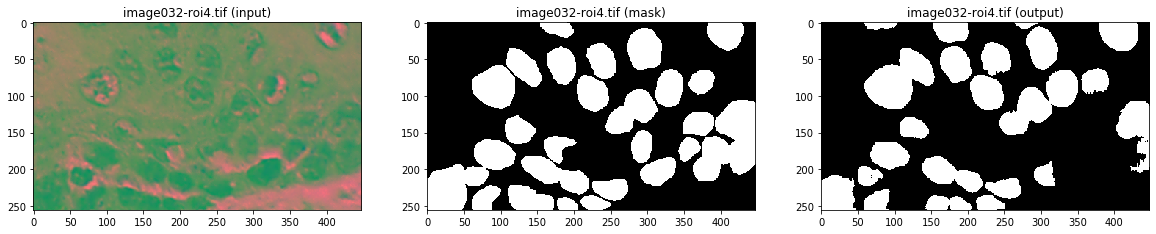

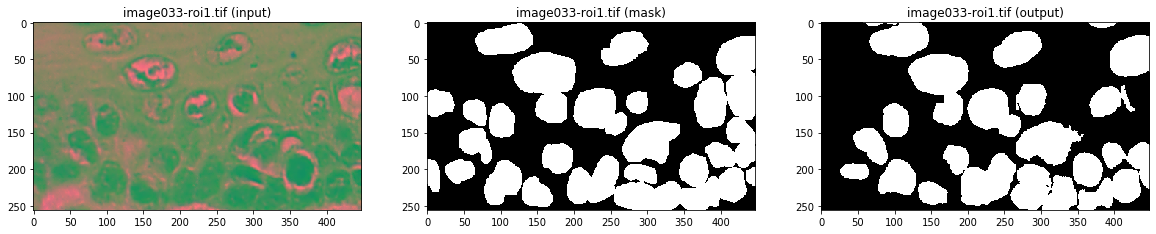

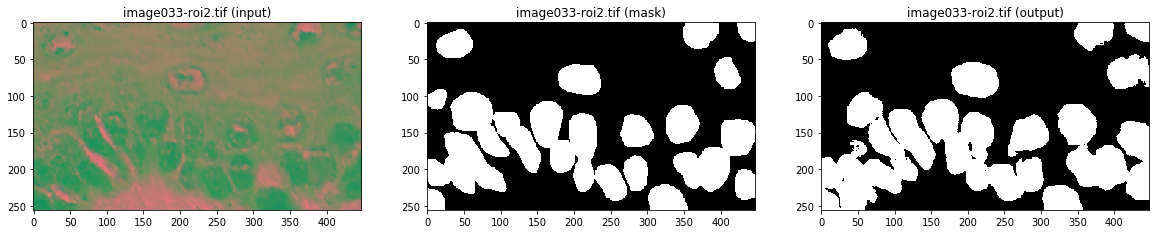

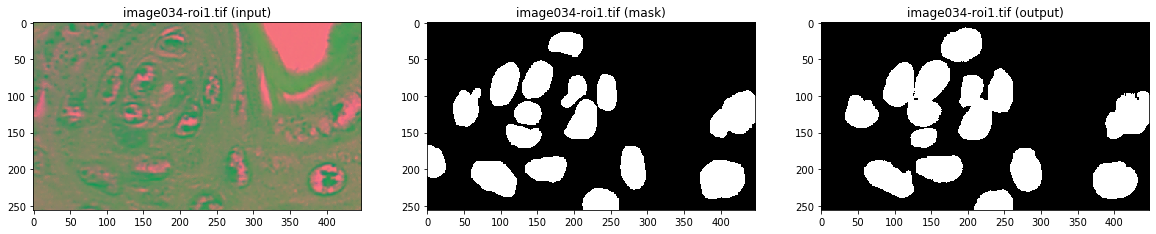

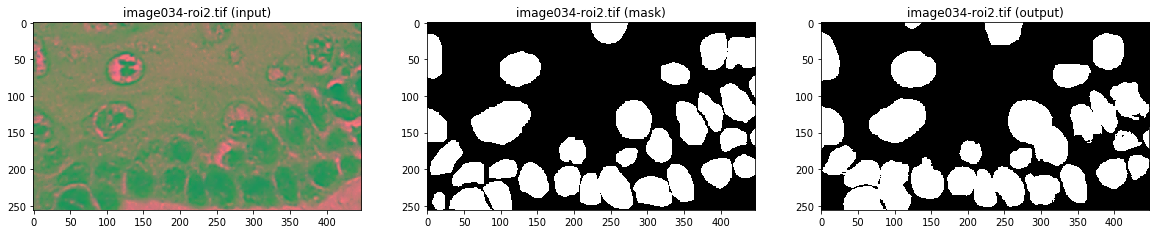

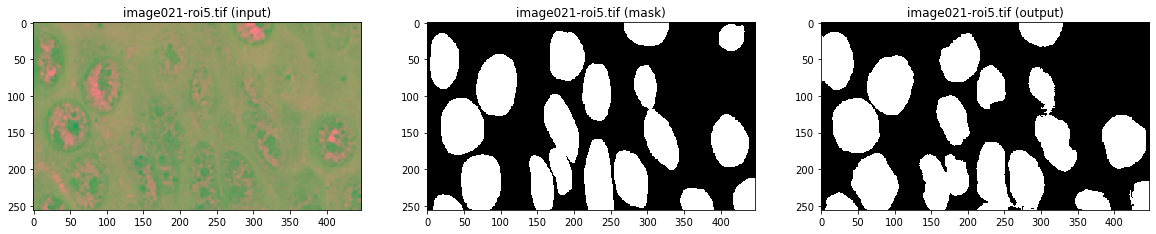

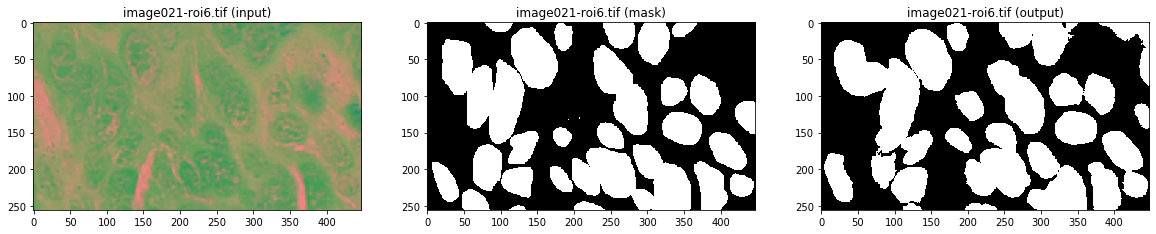

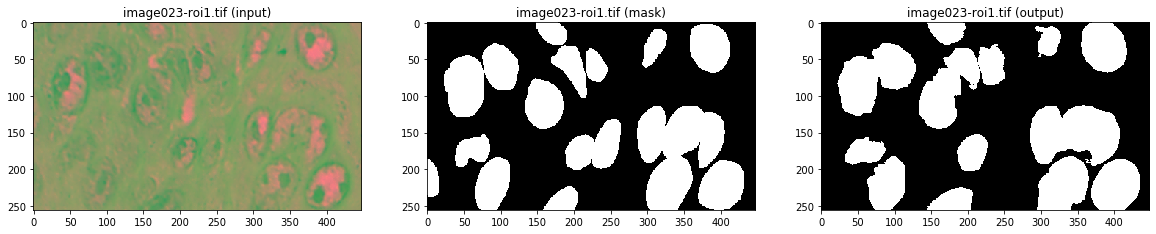

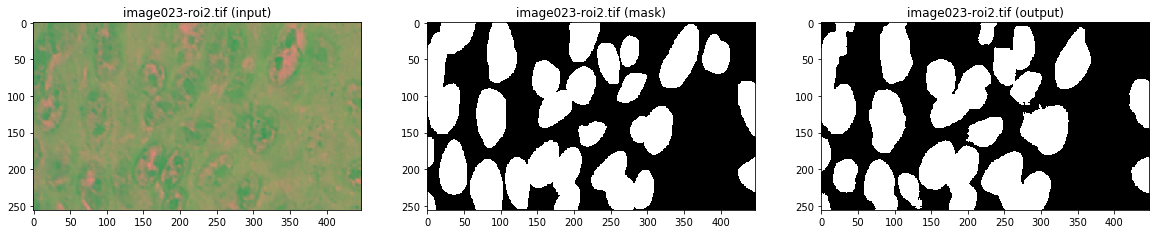

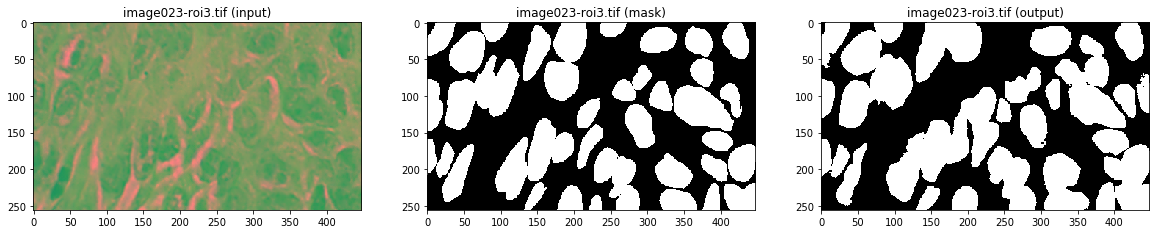

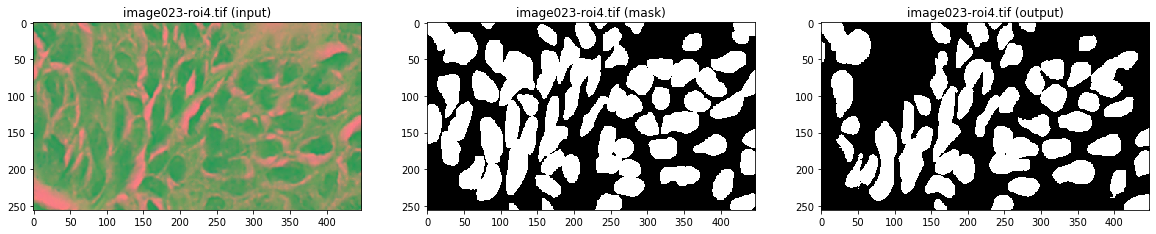

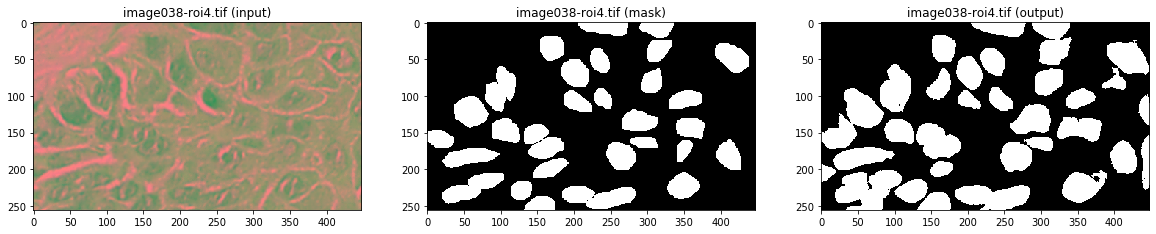

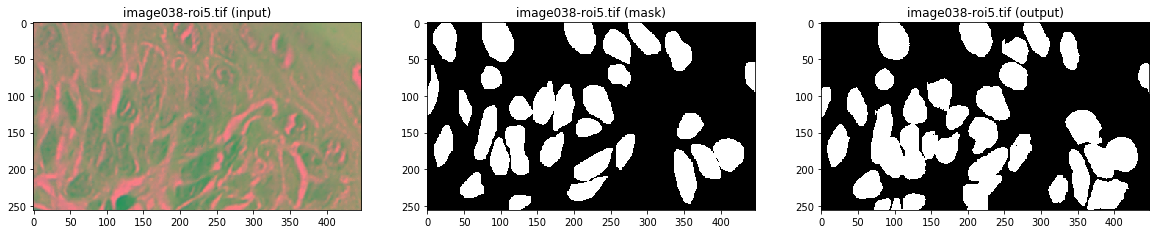

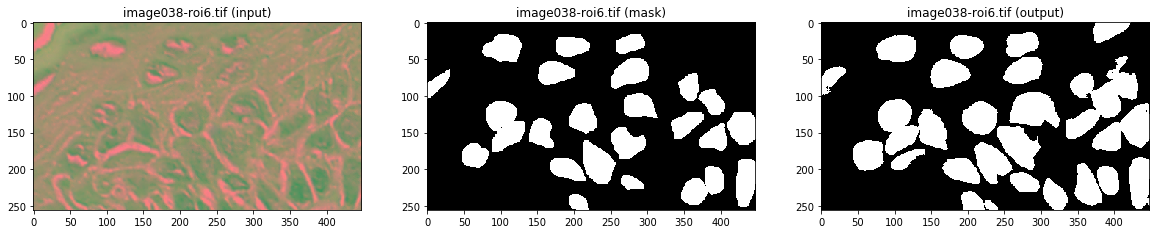

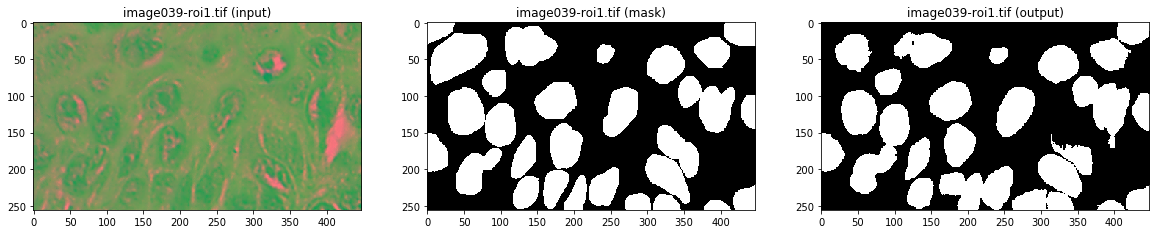

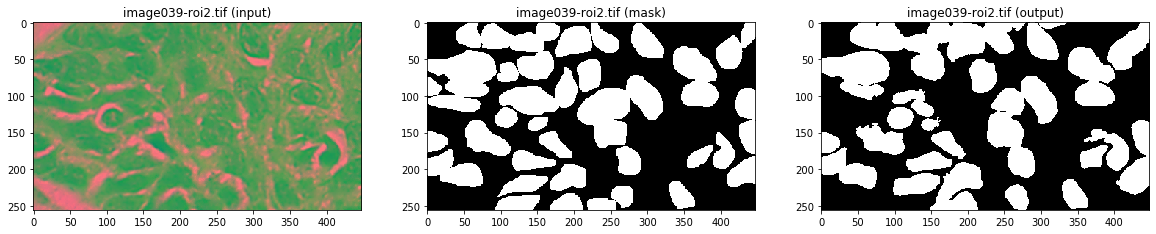

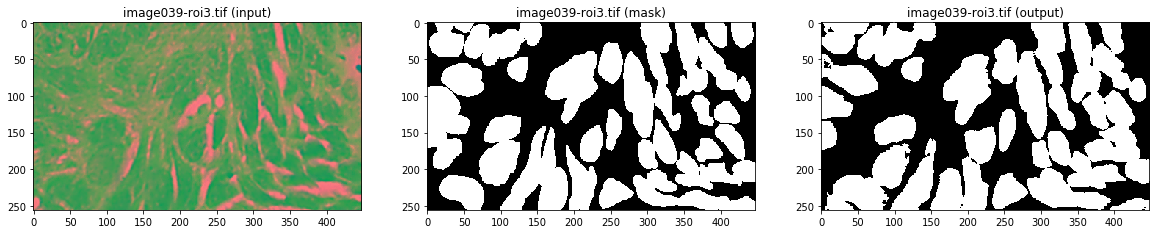

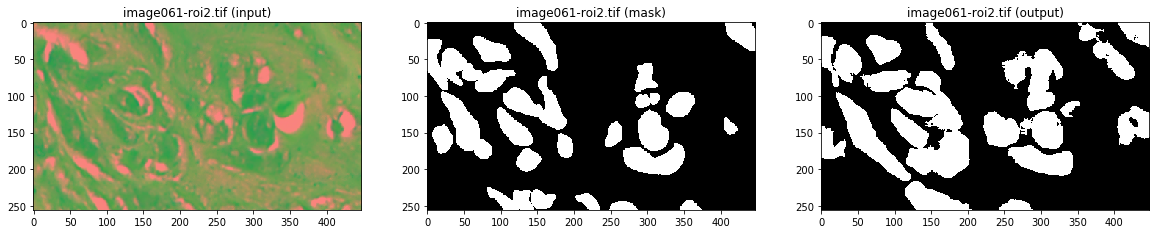

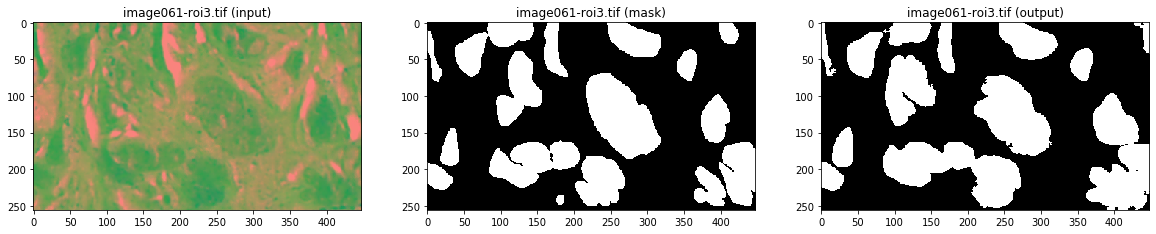

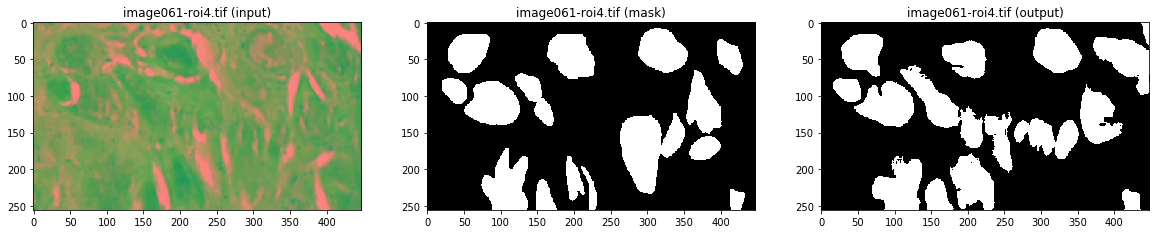

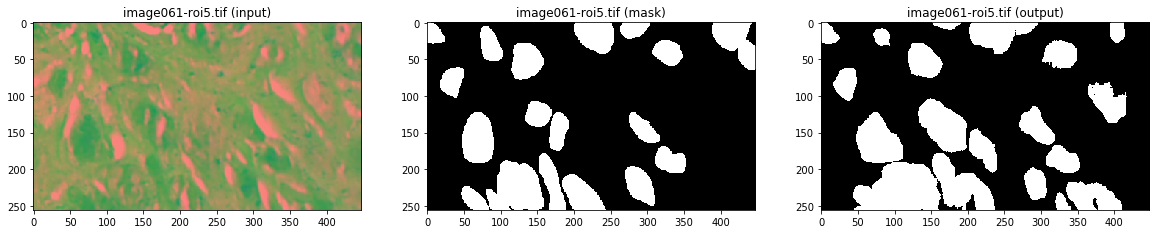

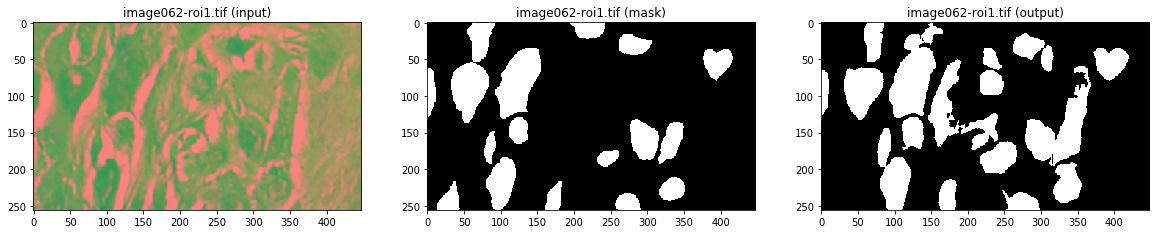

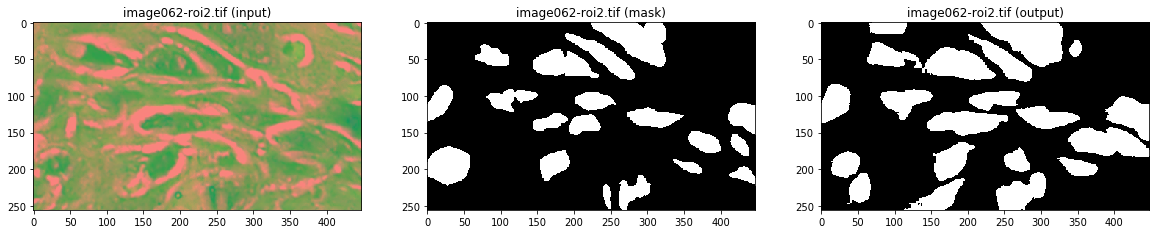

In [4]:
from unet_model import *
from oral_mice_tissues_dataset import *

from torchvision import transforms
from torchvision import utils
from torch.autograd import Variable

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print()
print('Runing on: {}'.format(device))

color_norm_methods = [
#    "1-original",
#    "2-khan_et_al", 
#    "3-macenko_et_al", 
#    "4-tosta_et_al", 
#    "5-reinhard_et_al", 
#    "6-vahadane_et_al",
    "7-original_hsv",
    "8-original_lab"
]
for color_normalization in color_norm_methods:

    # create the datasets
    batch_size = 1
    color_model = "HSV" if color_normalization == "7-original_hsv" else "LAB" if color_normalization == "8-original_lab" else "RGB"
    dataset_dir = "../histological_oral_mice_tissues/roi"
    method = "1-original" if "-original" in color_normalization else color_normalization
    dataloaders = create_dataloader(method, batch_size, dataset_dir, color_model)


    # directory to save results
    seg_method = "1-unet_based"
    results_dir = "results/{}/{}".format(color_normalization, seg_method)
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)


    # load the trained model
    epoch = 500
    model = UNet(in_channels=3, out_channels=1, padding=True).to(device)
    model = load_checkpoint(file_path="{}__Dataset-{}__Epoch-{}__Size-448x256.pt".format(model.name(), color_normalization, epoch))
    print()

    # iterate over test dataset images        
    t1 = datetime.now()
    print("{} {}".format(color_normalization, t1))
    for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):

        t = datetime.now()

        X = Variable(images.to(device))
        print('\tBatch {}: {}/{} images: {} masks: {} {}'.format(
            (batch_idx+1), 
            (batch_idx+1) * len(images), 
            len(dataloaders['test'].dataset),
            images.shape,
            masks.shape,
            datetime.now()))


        y_hat = model(X).squeeze(0)
        X_numpy = X.cpu().numpy()
        y_hat_numpy = y_hat.detach().cpu().numpy()


        input_image_filename  = '{}/{} - input.png'.format(results_dir, fname[0][0:-4])
        mask_image_filename   = '{}/{} - mask.png'.format(results_dir, fname[0][0:-4])
        output_image_filename = '{}/{} - output - 1.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_otsu  = '{}/{} - output - 2 - otsu.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_hyst  = '{}/{} - output - 3 - hysteresis.png'.format(results_dir, fname[0][0:-4])
        output_image_filename_basic = '{}/{} - output - 4 - basic.png'.format(results_dir, fname[0][0:-4])
        f, ax = plt.subplots(1, 3, figsize=(20, 20))


        # save the input image
        input_image = images[0]
        utils.save_image(input_image, input_image_filename)
        ax[0].imshow(input_image.permute(1, 2, 0))
        ax[0].set_title('{} (input)'.format(fname[0]))

        # save the mask image
        mask_image = masks[0]
        utils.save_image(mask_image, mask_image_filename)
        ax[1].imshow(mask_image, cmap='gray')
        ax[1].set_title('{} (mask)'.format(fname[0]))

        # save the predicted output image
        output_image = y_hat[0].squeeze(0).detach().cpu().numpy()
        output_image_otsu  = otsu_threshold(np_img=output_image)
        output_image_hyst  = hysteresis_threshold(np_img=output_image, low=0.2, high=0.8)
        output_image_basic = basic_threshold(np_img=output_image, threshold=0.2)

        utils.save_image(y_hat[0], output_image_filename)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_otsu)), output_image_filename_otsu)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_hyst)), output_image_filename_hyst)
        utils.save_image(TF.to_tensor(np_to_pil(output_image_basic)), output_image_filename_basic)

        ax[2].imshow(output_image_hyst, cmap='gray')
        ax[2].set_title('{} (output)'.format(fname[0]))
        

### Qualitative analysis

In [1]:
from torchvision import utils
from torchvision import transforms
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections

color_norm_methods = [
#    "1-original",
#    "2-khan_et_al", 
#    "3-macenko_et_al", 
#    "4-tosta_et_al", 
#    "5-reinhard_et_al", 
#    "6-vahadane_et_al",
    "7-original_hsv",
    "8-original_lab"
]
seg_methods = [
    "1-unet_based",
    "2-de_oliveira_et_al_(2013)", 
    "3-phoulady_et_al_(2016)", 
    "4-vahadane_and_sethi_(2013)", 
    "5-wienert_et_al_(2012)"
]
results_dir = "../dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                    for file in sorted(f_sef):
                        
                        threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                        if file.lower().endswith(threshold_type):
                            
                            input_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, 'input.png'))
                            mask_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, 'mask.png'))
                            output_filename = "{}/{}/{}".format(r, seg_method, file)

                            input_image = load_pil_image(input_filename)
                            mask_image = load_pil_image(mask_filename, gray=True)
                            output_image = load_pil_image(output_filename, gray=True)

                            
                            merge_image_output_b = cut_image_by_mask(input_image, output_image, inverse=True)
                            merge_image_mask_b = cut_image_by_mask(input_image, mask_image, inverse=True)

                            merge_image_output_f = cut_image_by_mask(input_image, output_image, inverse=False)
                            merge_image_mask_f = cut_image_by_mask(input_image, mask_image, inverse=False)

                                                        
                            utils.save_image(transforms.ToTensor()(merge_image_output_f), output_filename.replace(".png", "_2.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_f), output_filename.replace(".png", "_3.png"))
                            
                            utils.save_image(transforms.ToTensor()(merge_image_output_b), output_filename.replace(".png", "_4.png"))
                            utils.save_image(transforms.ToTensor()(merge_image_mask_b), output_filename.replace(".png", "_5.png"))


../dysplastic_oral_tissues_segmentation/results/7-original_hsv
	1-unet_based
	2-de_oliveira_et_al_(2013)
	3-phoulady_et_al_(2016)
	4-vahadane_and_sethi_(2013)
	5-wienert_et_al_(2012)
../dysplastic_oral_tissues_segmentation/results/8-original_lab
	1-unet_based
	2-de_oliveira_et_al_(2013)
	3-phoulady_et_al_(2016)
	4-vahadane_and_sethi_(2013)
	5-wienert_et_al_(2012)


### Quantitative analysis

In [1]:
from torchvision import utils
from image_utils import *
from experimental_evaluation import *

import os
import csv
import collections


color_norm_methods = [
#    "1-original",
#    "2-khan_et_al", 
#    "3-macenko_et_al", 
#    "4-tosta_et_al", 
#    "5-reinhard_et_al", 
#    "6-vahadane_et_al",
    "7-original_hsv",
    "8-original_lab"
]
seg_methods = [
    "1-unet_based",
    "2-de_oliveira_et_al_(2013)", 
    "3-phoulady_et_al_(2016)", 
    "4-vahadane_and_sethi_(2013)", 
    "5-wienert_et_al_(2012)"
]
results_dir = "../dysplastic_oral_tissues_segmentation/results"

for r, d, f in sorted(os.walk(results_dir)):
    for norm_method in sorted(color_norm_methods):
        if (r.endswith(norm_method)):
            
            print(r)
            for seg_method in sorted(seg_methods):
                
                print("\t{}".format(seg_method))
                seg_method_dir = "{}/{}".format(r, seg_method)
                
                if os.path.exists(seg_method_dir):
                    with open('{}/quantitative_analysis.csv'.format(seg_method_dir), mode='w') as medidas_file:
                        medidas_writer = csv.writer(medidas_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                        medidas_writer.writerow(['image', 'accuracy', 'precision', 'f1/dice', 'jaccard', 'sensitivity/recall', 'specificity'])

                        for r_seg, d_seg, f_sef in sorted(os.walk(seg_method_dir)):
                            for file in sorted(f_sef):

                                threshold_type = "output - 2 - otsu.png" if seg_method == "1-unet_based" else "output.png"
                                if file.lower().endswith(threshold_type):

                                    mask_filename = "{}/{}/{}".format(r, "1-unet_based", file.replace(threshold_type, "mask.png"))
                                    output_filename = "{}/{}/{}".format(r, seg_method, file)

                                    accuracy = pixel_accuracy_score(mask_filename, output_filename)
                                    jaccard = jaccard_index_score(mask_filename, output_filename)
                                    precision = precision_score(mask_filename, output_filename)
                                    recall = recall_score(mask_filename, output_filename)
                                    f1 = f1_score(mask_filename, output_filename)
                                    sensitivity = sensitivity_score(mask_filename, output_filename)
                                    specificity = specificity_score(mask_filename, output_filename)
                                    dice = dice_score(mask_filename, output_filename)

                                    print(file.replace(" - " + threshold_type, ""))
                                    print('\t{}: \t\t{}'.format('accuracy', accuracy))
                                    print('\t{}: \t\t{}'.format('precision', precision))
                                    print('\t{}: \t\t{}'.format('f1/dice', f1))
                                    print('\t{}: \t\t{}'.format('jaccard', jaccard))
                                    print('\t{}: \t{}'.format('sensitivity/recall', sensitivity))
                                    print('\t{}: \t\t{}'.format('specificity', specificity))
                                    print()

                                    medidas_writer.writerow([file.replace(" - " + threshold_type, ""), accuracy, precision, f1, jaccard, sensitivity, specificity])

../dysplastic_oral_tissues_segmentation/results/7-original_hsv
	1-unet_based
image021-roi5
	accuracy: 		0.9192679268973214
	precision: 		0.9426334001092697
	f1/dice: 		0.8867026418511311
	jaccard: 		0.7964652348816249
	sensitivity/recall: 	0.8370373792912258
	specificity: 		0.9691185120864961

image021-roi6
	accuracy: 		0.8799700055803571
	precision: 		0.8628270687917584
	f1/dice: 		0.8704132542596253
	jaccard: 		0.7705590186339545
	sensitivity/recall: 	0.8781340221850783
	specificity: 		0.8815280464216635

image023-roi1
	accuracy: 		0.91888427734375
	precision: 		0.9013770290022309
	f1/dice: 		0.8831354814396081
	jaccard: 		0.7907274935888784
	sensitivity/recall: 	0.8656176122931442
	specificity: 		0.9480831533477322

image023-roi2
	accuracy: 		0.9082554408482143
	precision: 		0.8862583847320001
	f1/dice: 		0.8902517888061414
	jaccard: 		0.8022106094214069
	sensitivity/recall: 	0.8942813436432597
	specificity: 		0.9182134484148909

image023-roi3
	accuracy: 		0.85003662109375
	precisio

image038-roi6
	accuracy: 		0.7970319475446429
	precision: 		0.5466623385656982
	f1/dice: 		0.669496819627442
	jaccard: 		0.5031906946964038
	sensitivity/recall: 	0.8635314800571365
	specificity: 		0.776254505922069

image039-roi1
	accuracy: 		0.7574026925223214
	precision: 		0.8135251988514473
	f1/dice: 		0.6392292631060282
	jaccard: 		0.46975529806372923
	sensitivity/recall: 	0.5264405621289138
	specificity: 		0.9167477087201249

image039-roi2
	accuracy: 		0.5047433035714286
	precision: 		0.03554088172460672
	f1/dice: 		0.006402407025154812
	jaccard: 		0.0032114841268448486
	sensitivity/recall: 	0.0035180806274871675
	specificity: 		0.9207607984554259

image039-roi3
	accuracy: 		0.4312656947544643
	precision: 		0.06417868249929319
	f1/dice: 		0.006912196830133524
	jaccard: 		0.0034680844562593577
	sensitivity/recall: 	0.003652806385169928
	specificity: 		0.9370051766138855

image061-roi2
	accuracy: 		0.7234758649553571
	precision: 		0.45416946590527374
	f1/dice: 		0.5770338757001866
	

image023-roi3
	accuracy: 		0.5293143136160714
	precision: 		1.0
	f1/dice: 		0.0022917975825231954
	jaccard: 		0.0011472133816889942
	sensitivity/recall: 	0.0011472133816889942
	specificity: 		1.0

image023-roi4
	accuracy: 		0.5168805803571429
	precision: 		0.014240506329113924
	f1/dice: 		0.00032475733410312847
	jaccard: 		0.00016240503816518397
	sensitivity/recall: 	0.0001642515603898237
	specificity: 		0.9895982903128862

image032-roi3
	accuracy: 		0.7887050083705357
	precision: 		0.3307408923454769
	f1/dice: 		0.06251692521954427
	jaccard: 		0.032267081985543705
	sensitivity/recall: 	0.03452106297530548
	specificity: 		0.9820884730834119

image032-roi4
	accuracy: 		0.5952584402901786
	precision: 		0.03772290809327846
	f1/dice: 		0.004717082270203049
	jaccard: 		0.002364117002299641
	sensitivity/recall: 	0.002515838345950644
	specificity: 		0.9604593813851899

image033-roi1
	accuracy: 		0.5440761021205357
	precision: 		0.609375
	f1/dice: 		0.04009325720999394
	jaccard: 		0.0204567168

image061-roi2
	accuracy: 		0.7130650111607143
	precision: 		0.12614308768154922
	f1/dice: 		0.053932842686292545
	jaccard: 		0.027713762335283342
	sensitivity/recall: 	0.03429866900687436
	specificity: 		0.9256010991527365

image061-roi3
	accuracy: 		0.6206229073660714
	precision: 		0.16746302616609784
	f1/dice: 		0.0633745210315581
	jaccard: 		0.03272420079142768
	sensitivity/recall: 	0.03908241291418862
	specificity: 		0.9049906522642294

image061-roi4
	accuracy: 		0.6855555943080357
	precision: 		0.1779976866726642
	f1/dice: 		0.07133108438699044
	jaccard: 		0.036984618671224094
	sensitivity/recall: 	0.0446026020868221
	specificity: 		0.923525754459802

image061-roi5
	accuracy: 		0.71197509765625
	precision: 		0.12995263948249972
	f1/dice: 		0.06377008757758694
	jaccard: 		0.03293518355875637
	sensitivity/recall: 	0.04225193419965447
	specificity: 		0.9144693511389703

image062-roi1
	accuracy: 		0.7579258510044643
	precision: 		0.10655446248666588
	f1/dice: 		0.06082338215892561
	ja

image033-roi1
	accuracy: 		0.7340175083705357
	precision: 		0.8778625954198473
	f1/dice: 		0.6281011886619933
	jaccard: 		0.45783346663112057
	sensitivity/recall: 	0.48898084698468136
	specificity: 		0.9422000741851726

image033-roi2
	accuracy: 		0.8196934291294643
	precision: 		0.8939321737749186
	f1/dice: 		0.6852559321775924
	jaccard: 		0.5212086131048854
	sensitivity/recall: 	0.5555665243466028
	specificity: 		0.963987649826747

image034-roi1
	accuracy: 		0.3077305385044643
	precision: 		0.20665752589884218
	f1/dice: 		0.32358980038678786
	jaccard: 		0.19302543044742138
	sensitivity/recall: 	0.7453004199207253
	specificity: 		0.1827435066754851

image034-roi2
	accuracy: 		0.8155255998883929
	precision: 		0.878254617014835
	f1/dice: 		0.6868923058708617
	jaccard: 		0.5231043188170589
	sensitivity/recall: 	0.5640022358859698
	specificity: 		0.9562556941026095

image038-roi4
	accuracy: 		0.6391950334821429
	precision: 		0.40535603559518024
	f1/dice: 		0.5389723249699184
	jaccard: 		0.

image062-roi1
	accuracy: 		0.8018537248883929
	precision: 		0.4637668039650568
	f1/dice: 		0.47416525904158086
	jaccard: 		0.3107579387946984
	sensitivity/recall: 	0.4850407119863662
	specificity: 		0.873380787482365

image062-roi2
	accuracy: 		0.7887747628348214
	precision: 		0.4839780911717773
	f1/dice: 		0.480918811202297
	jaccard: 		0.31658532456907496
	sensitivity/recall: 	0.4778979643982625
	specificity: 		0.8688134552551368

	4-vahadane_and_sethi_(2013)
image021-roi5
	accuracy: 		0.647705078125
	precision: 		0.6513973523849548
	f1/dice: 		0.23483069464434508
	jaccard: 		0.1330357909192344
	sensitivity/recall: 	0.14323337799750496
	specificity: 		0.9535307134253942

image021-roi6
	accuracy: 		0.6818150111607143
	precision: 		0.7719315963105097
	f1/dice: 		0.5568885542900164
	jaccard: 		0.3858943506722986
	sensitivity/recall: 	0.4355531074304817
	specificity: 		0.8907962604771116

image023-roi1
	accuracy: 		0.6686139787946429
	precision: 		0.6433450859409432
	f1/dice: 		0.23504548

image038-roi4
	accuracy: 		0.7715366908482143
	precision: 		0.9397508493771235
	f1/dice: 		0.2405217391304348
	jaccard: 		0.1367006029455372
	sensitivity/recall: 	0.13790925710486954
	specificity: 		0.9968559034549602

image038-roi5
	accuracy: 		0.7536708286830357
	precision: 		0.9078673289536933
	f1/dice: 		0.28628451608013544
	jaccard: 		0.16705486923961435
	sensitivity/recall: 	0.1699358166876612
	specificity: 		0.9929314287119219

image038-roi6
	accuracy: 		0.7930995396205357
	precision: 		0.9624741200828157
	f1/dice: 		0.23864985401225655
	jaccard: 		0.13549256776450014
	sensitivity/recall: 	0.1362121378603084
	specificity: 		0.9983406763174458

image039-roi1
	accuracy: 		0.6702444893973214
	precision: 		0.9100100191274251
	f1/dice: 		0.3457033615335375
	jaccard: 		0.2089730181970299
	sensitivity/recall: 	0.21338259792405279
	specificity: 		0.9854419002151298

image039-roi2
	accuracy: 		0.6505039760044643
	precision: 		0.8883754230669096
	f1/dice: 		0.4051290423116309
	jaccard: 		

In [7]:
target = "/mnt/DADOS/PhD/github/dysplastic_oral_tissues_segmentation/results/7-original_hsv/5-wienert_et_al_(2012)/image023-roi1 - mask.png"
prediction = "/mnt/DADOS/PhD/github/dysplastic_oral_tissues_segmentation/results/7-original_hsv/5-wienert_et_al_(2012)/image023-roi1 - output.png"


mask_np = image_path_to_np(target)
output_np = image_path_to_np(prediction).copy()
if np.unique(output_np).size:
    output_np[output_np > 0] = 255
print(np.unique(mask_np))
print(np.unique(output_np).size)

jaccard = metrics.jaccard_score(mask_np, output_np, average='micro')
print(jaccard)

[  0 255]
2
0.0681091113336101
